# Forecasting Stock Prices Using Time Series

## Libraries and Data Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from copy import deepcopy

# Google Data

In [2]:
data1 = pd.read_csv('c:Downloads/GOOGL_data.csv')
data1

,date,open,high,low,close,volume,Name
0,2013-02-08,390.4551,393.7283,390.1698,393.0777,6031199,GOOGL
1,2013-02-11,389.5892,391.8915,387.2619,391.6012,4330781,GOOGL
2,2013-02-12,391.2659,394.3440,390.0747,390.7403,3714176,GOOGL
3,2013-02-13,390.4551,393.0677,390.3750,391.8214,2393946,GOOGL
4,2013-02-14,390.2549,394.7644,389.2739,394.3039,3466971,GOOGL
...,...,...,...,...,...,...,...
1254,2018-02-01,1175.9900,1187.4500,1169.3600,1181.5900,3675709,GOOGL
1255,2018-02-02,1127.4200,1131.3000,1111.1700,1119.2000,5892122,GOOGL
1256,2018-02-05,1100.6100,1114.9900,1056.7400,1062.3900,4177469,GOOGL
1257,2018-02-06,1033.9800,1087.3800,1030.0100,1084.4300,3831524,GOOGL


## Data Preprocessing

In [3]:
# to convert str to date-time
def str_to_datetime(s):
    for fmt in ('%m/%d/%Y', '%Y-%m-%d'):
        try:
            return datetime.strptime(s, fmt)
        except ValueError:
            continue
    raise ValueError(f"Date format for '{s}' not recognized")


data1['date'] = data1['date'].apply(str_to_datetime)
data1.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,390.4551,393.7283,390.1698,393.0777,6031199,GOOGL
1,2013-02-11,389.5892,391.8915,387.2619,391.6012,4330781,GOOGL
2,2013-02-12,391.2659,394.3440,390.0747,390.7403,3714176,GOOGL
3,2013-02-13,390.4551,393.0677,390.3750,391.8214,2393946,GOOGL
4,2013-02-14,390.2549,394.7644,389.2739,394.3039,3466971,GOOGL


In [4]:
data1['date']

0      2013-02-08
1      2013-02-11
2      2013-02-12
3      2013-02-13
4      2013-02-14
          ...    
1254   2018-02-01
1255   2018-02-02
1256   2018-02-05
1257   2018-02-06
1258   2018-02-07
Name: date, Length: 1259, dtype: datetime64[ns]

In [5]:
data1.index = data1.pop('date')
data1.head()

,open,high,low,close,volume,Name
date,,,,,,
2013-02-08,390.4551,393.7283,390.1698,393.0777,6031199,GOOGL
2013-02-11,389.5892,391.8915,387.2619,391.6012,4330781,GOOGL
2013-02-12,391.2659,394.3440,390.0747,390.7403,3714176,GOOGL
2013-02-13,390.4551,393.0677,390.3750,391.8214,2393946,GOOGL
2013-02-14,390.2549,394.7644,389.2739,394.3039,3466971,GOOGL


In [6]:
print("Missing values in Google data:\n", data1.isnull().sum())
data1 = data1.fillna(method='ffill')
print("Missing values after filling Google data:\n\n", data1.isnull().sum())

Missing values in Google data:
 open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64
Missing values after filling Google data:

 open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64


In [7]:
print("Min date:", data1.index.min())
print("Max date:", data1.index.max())

Min date: 2013-02-08 00:00:00
Max date: 2018-02-07 00:00:00


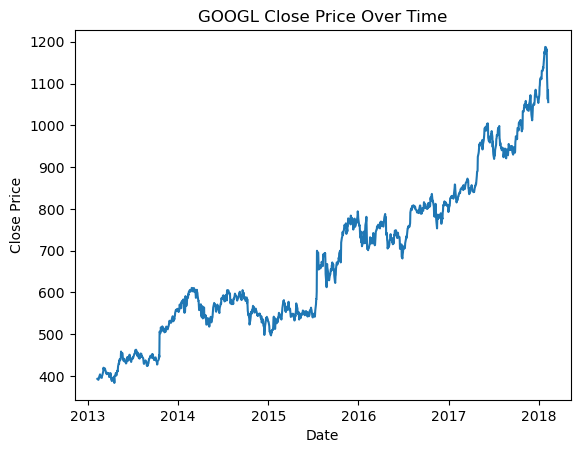

In [8]:
plt.plot(data1.index, data1['close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('GOOGL Close Price Over Time')
plt.show()

## Creating Windowed Data
#### help the model learn patterns to make it easier to predict future values

In [9]:
def data_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)
    
    if first_date < dataframe.index.min() or last_date > dataframe.index.max():
        raise ValueError("The date range is out of bounds of the available data.")
    
    target_date = first_date
    dates = []
    X, Y = [], []

    while target_date <= last_date:
      df_subset = dataframe.loc[:target_date].tail(n + 1)

      if len(df_subset) < n + 1:
        print(f'Warning: Not enough data available for window of size {n} at date {target_date}')
        break

      values = df_subset['close'].to_numpy()
      x, y = values[:-1], values[-1]

      next_date = target_date + timedelta(days=1)
      if next_date in dataframe.index:
        dates.append(target_date)
        X.append(x)
        Y.append(y)
      else:
        print(f'Data unavailable for {next_date}, advancing window by 1 day.')
      target_date = next_date

    
    if not dates:
        print("No valid windows available.")
        return pd.DataFrame(columns=['Target Date'] + [f'Target-{i+1}' for i in range(n)] + ['Target'])

    X = np.array(X)
    Y = np.array(Y)

    if X.ndim == 2:
        X = X.reshape((X.shape[0], n, 1))
    elif X.ndim == 1:
        X = X.reshape((len(X), n, 1))
    
    print(f"Dates: {dates}")
    print(f"X shape: {X.shape}")
    print(f"Y shape: {Y.shape}")

    ret_df = pd.DataFrame({'Target Date': dates})
    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i, 0]
    
    ret_df['Target'] = Y

    return ret_df




windowed_df = data_to_windowed_df(data1, '2013-08-02', '2018-02-07', n=3)
windowed_df

Data unavailable for 2013-08-03 00:00:00, advancing window by 1 day.
Data unavailable for 2013-08-04 00:00:00, advancing window by 1 day.
Data unavailable for 2013-08-10 00:00:00, advancing window by 1 day.
Data unavailable for 2013-08-11 00:00:00, advancing window by 1 day.
Data unavailable for 2013-08-17 00:00:00, advancing window by 1 day.
Data unavailable for 2013-08-18 00:00:00, advancing window by 1 day.
Data unavailable for 2013-08-24 00:00:00, advancing window by 1 day.
Data unavailable for 2013-08-25 00:00:00, advancing window by 1 day.
Data unavailable for 2013-08-31 00:00:00, advancing window by 1 day.
Data unavailable for 2013-09-01 00:00:00, advancing window by 1 day.
Data unavailable for 2013-09-02 00:00:00, advancing window by 1 day.
Data unavailable for 2013-09-07 00:00:00, advancing window by 1 day.
Data unavailable for 2013-09-08 00:00:00, advancing window by 1 day.
Data unavailable for 2013-09-14 00:00:00, advancing window by 1 day.
Data unavailable for 2013-09-15 00

,Target Date,Target-3,Target-2,Target-1,Target
0,2013-08-04,445.9055,444.3189,452.5621,453.7383
1,2013-08-05,444.3189,452.5621,453.7383,452.9525
2,2013-08-06,452.5621,453.7383,452.9525,448.7333
3,2013-08-07,453.7383,452.9525,448.7333,445.7703
4,2013-08-08,452.9525,448.7333,445.7703,446.7763
...,...,...,...,...,...
1132,2018-01-31,1187.5600,1186.4800,1177.3700,1182.2200
1133,2018-02-01,1186.4800,1177.3700,1182.2200,1181.5900
1134,2018-02-04,1177.3700,1182.2200,1181.5900,1119.2000
1135,2018-02-05,1182.2200,1181.5900,1119.2000,1062.3900


## Model Training and Evaluation

In [10]:
# to convert windowed dataframe to array x,y
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)
dates.shape, X.shape, y.shape

((1137,), (1137, 3, 1), (1137,))

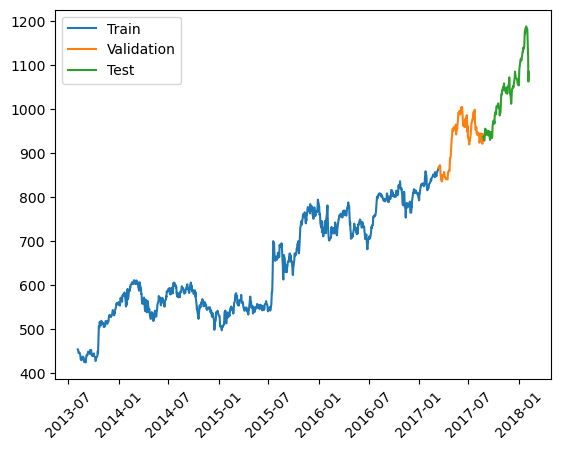

In [11]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.xticks(rotation=45)
plt.legend(['Train', 'Validation', 'Test'])

In [12]:
model = Sequential([
    layers.Input((3, 1)),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 423870.5938 - mean_absolute_error: 640.4464 - val_loss: 863377.1875 - val_mean_absolute_error: 927.7773
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 421525.2812 - mean_absolute_error: 638.6069 - val_loss: 852682.4375 - val_mean_absolute_error: 921.9957
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 404107.8750 - mean_absolute_error: 625.0861 - val_loss: 832867.5000 - val_mean_absolute_error: 911.1866
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 391083.3125 - mean_absolute_error: 614.6550 - val_loss: 792112.3750 - val_mean_absolute_error: 888.5414
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 365697.0312 - mean_absolute_error: 593.2938 - val_loss: 726994.3125 - val_mean_absolute_error: 851.1098
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 313781.5312 - mean_absolute_error: 547.8959 - val_loss: 631495.9375 - val_mean_absolute_error: 793.0256
Epoch 7/100
29/29 ━━━━

In [35]:
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

print("Training RMSE:", np.sqrt(mean_squared_error(y_train, train_predictions)))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, val_predictions)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_predictions)))
print("Training MAE:", mean_absolute_error(y_train, train_predictions))
print("Validation MAE:", mean_absolute_error(y_val, val_predictions))
print("Test MAE:", mean_absolute_error(y_test, test_predictions))

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
Training RMSE: 11.737276
Validation RMSE: 90.420746
Test RMSE: 262.92612
Training MAE: 8.949687
Validation MAE: 82.59759
Test MAE: 227.36339


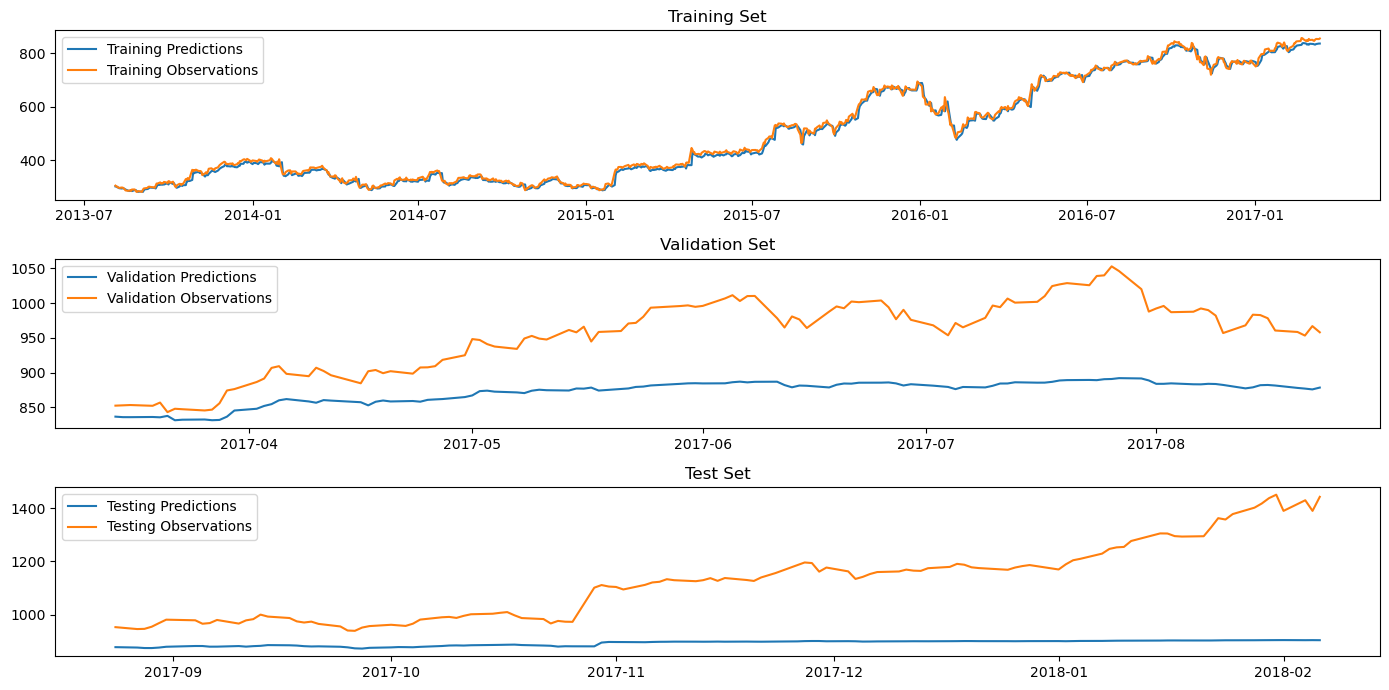

In [49]:
plt.figure(figsize=(14, 7))
plt.subplot(3, 1, 1)
plt.plot(dates_train, train_predictions, label='Training Predictions')
plt.plot(dates_train, y_train, label='Training Observations')
plt.legend()
plt.title('Training Set')

plt.subplot(3, 1, 2)
plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.legend()
plt.title('Validation Set')

plt.subplot(3, 1, 3)
plt.plot(dates_test, test_predictions, label='Testing Predictions')
plt.plot(dates_test, y_test, label='Testing Observations')
plt.legend()
plt.title('Test Set')

plt.tight_layout()
plt.show()

#### plot predictions

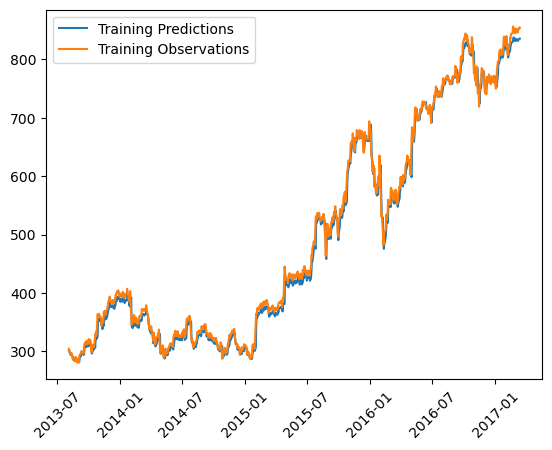

In [42]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.xticks(rotation=45)
plt.legend(['Training Predictions', 'Training Observations'])

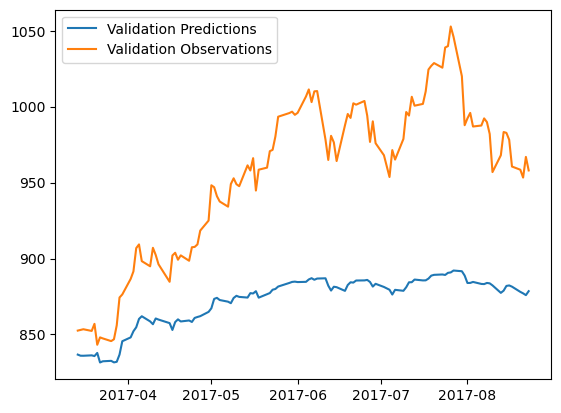

In [43]:
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.show()

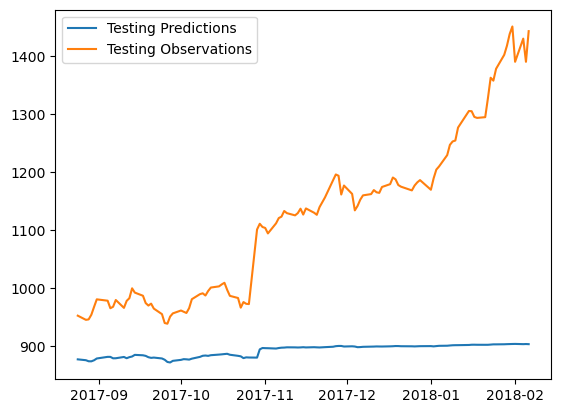

In [44]:
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])
plt.show()

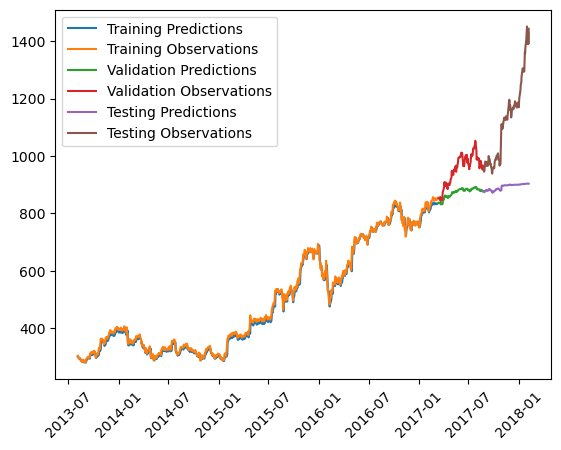

In [45]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.xticks(rotation=45)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])
plt.show()

## Recursive Predictions
#### makeing a prediction, and this prediction is used as part of the input for future predictions

In [17]:
recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

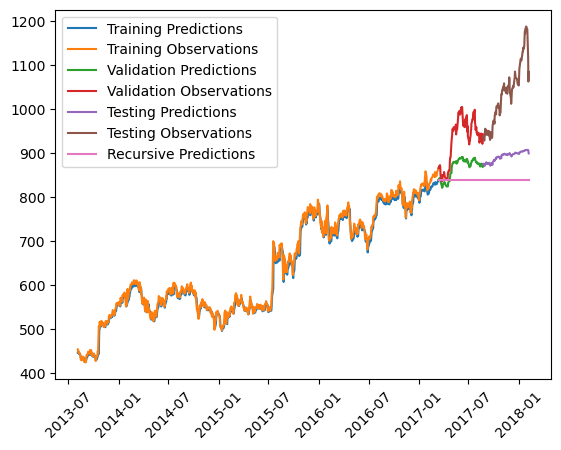

In [18]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.xticks(rotation=45)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])